
# Parte #01 — Limpeza e Preparação do Dataset

- `source/tic-tac-toe.data` — tabuleiros (9 casas) + classe original da UCI (*positive/negative*)
- `source/tic-tac-toe.names` — metadados originais
- `source/descricao_trabalho.md` — instruções do trabalho

**Rótulos de saída:**
- `0` = **Tem Jogo**
- `1` = **Possível Fim de Jogo**
- `2` = **Fim de Jogo**

> Observação: o dataset original contém **apenas posições finais** de jogo da velha; necessário tratar o, ao aplicarmos nossas regras, todas as linhas do dataset original caem inicialmente na classe `2`.


Abaixo, verificamos existência dos arquivos de dataset originais fornecidos para o T1

In [132]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/source')
RAW_DATA = DATA_DIR/'tic-tac-toe.data'
RAW_NAMES = DATA_DIR/'tic-tac-toe.names'

RAW_DATA, RAW_NAMES, RAW_DATA.exists(), RAW_NAMES.exists()

(PosixPath('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/source/tic-tac-toe.data'),
 PosixPath('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/source/tic-tac-toe.names'),
 True,
 True)


### 1. Carregar dataset cru e inspecionar schema
**Limpeza do dataset - problemas encontrados:**
- O arquivo não possui cabeçalhos
- Possui **10 colunas**: 9 casas do tabuleiro (`x`, `o`, `b`) + **classe original UCI** (`positive/negative`).
- Este dataset possui outro objetivo de análise, possui apenas condições de fim de jogo para um dos jogadores. Suas classes representam:
- - positive ⇒ posição de fim de jogo em que X venceu (X tem três em linha);

- - negative ⇒ todas as outras posições finais (empate ou vitória de O). 
- Portanto, para nosso objetivo, não podemos utilizar estas classes, mas manteremos no dataset para referência histórica

In [133]:
raw = pd.read_csv(RAW_DATA, header=None)
raw.columns = list(range(9)) + ['uci_class']
display(raw.head())
print('Shape:', raw.shape)
print('Distribuicao uci_class:')
print(raw['uci_class'].value_counts())

,0,1,2,3,4,5,6,7,8,uci_class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


Shape: (958, 10)
Distribuicao uci_class:
uci_class
positive    626
negative    332
Name: count, dtype: int64


### 2. Definir funções auxiliares de classificação

Definimos abaixo as funções que irão ajudar a definir o estado de cada entrada do dataset:

*possui_vencedor(tabuleiro)*: define se a linha possui vencedor, ou seja, se alguma das combinações de vitória (definida em *LINES*[]) possui uma sequência do mesmo jogador, neste caso, X (já que o dataset possui apenas vitórias dele)

*possui_dois_e_vazio(tabuleiro)*: verifica se alguma das linhas de jogo podem estar prestes a terminar o jogo com vitória

*classificacao_jogo(tabuleiro)*: utiliza as duas funções anteriores para classificar a partida conforme abaixo:

`label_int`
1. **Fim de Jogo (2)**: há `XXX` ou `OOO` **ou** não há `b` (empate).
2. **Possível Fim de Jogo (1)**: (se não for 2) existe linha/coluna/diagonal com **duas iguais + um vazio**.
3. **Tem Jogo (0)**: caso contrário.


In [134]:
LINES = [
    (0,1,2),(3,4,5),(6,7,8),
    (0,3,6),(1,4,7),(2,5,8),
    (0,4,8),(2,4,6)
]

def possui_vencedor(tabuleiro):
    for i,j,k in LINES:
        a,b,c = tabuleiro[i],tabuleiro[j],tabuleiro[k]
        if a != 'b' and a==b==c:
            return True
    return False

def vencedor(tabuleiro):
    for i,j,k in LINES:
        a,b,c = tabuleiro[i],tabuleiro[j],tabuleiro[k]
        if a != 'b' and a==b==c:
            return a
    return None

def possui_dois_e_vazio(tabuleiro):
    for i,j,k in LINES:
        trip = [tabuleiro[i],tabuleiro[j],tabuleiro[k]]
        if trip.count('b')==1:
            nonb = [t for t in trip if t!='b']
            if len(nonb)==2 and nonb[0]==nonb[1]:
                return True
    return False

def classificacao_jogo(tabuleiro):
    if possui_vencedor(tabuleiro) or ('b' not in tabuleiro):
        return 2
    if possui_dois_e_vazio(tabuleiro):
        return 1
    return 0

#funções auxiliares de visualização do tabuleiro

def board_to_str(b): return ''.join(b)
def str_to_board(s): return list(s)

### 3. Aplicar rotulagem e inspecionar resultados

In [135]:
raw['label_int'] = raw[list(range(9))].apply(lambda r: classificacao_jogo(r.tolist()), axis=1)
mapping = {0:'Tem Jogo', 1:'Possível Fim de Jogo', 2:'Fim de Jogo'}
raw['label'] = raw['label_int'].map(mapping)
display(raw.head())
raw['label_int'].value_counts().sort_index()

,0,1,2,3,4,5,6,7,8,uci_class,label_int,label
0,x,x,x,x,o,o,x,o,o,positive,2,Fim de Jogo
1,x,x,x,x,o,o,o,x,o,positive,2,Fim de Jogo
2,x,x,x,x,o,o,o,o,x,positive,2,Fim de Jogo
3,x,x,x,x,o,o,o,b,b,positive,2,Fim de Jogo
4,x,x,x,x,o,o,b,o,b,positive,2,Fim de Jogo


label_int
2    958
Name: count, dtype: int64


### 4. Salvar `tic_tac_toe_clean.csv`
Colunas:
- 9 casas do tabuleiro
- `uci_class` (original)
- `label_int` (0/1/2) e `label` (texto)


In [136]:
cleaned = raw.copy()
cleaned_path = Path('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/tic_tac_toe_clean.csv')
cleaned.to_csv(cleaned_path, index=False)
cleaned_path, cleaned.shape

(PosixPath('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/tic_tac_toe_clean.csv'),
 (958, 12))

Temos um dataset com 958 entradas e 12 atributos - um atributo para cada quadrado de jogo do tabuleiro do jogo da velha, um atributo legado `uci_class`, e as classificações de saída `label_int` (inteiro) e `label` (string). Utilizaremos a coluna de inteiros para processamento dos modelos, e a de string apenas para referência e visualização.

Ainda não podemos utilizar este dataset pois contempla apenas estados finais. Precisaremos utilizar de augmentação para que o dataset tenha modelos com as três classes

# Parte #02 — Augmentação das Classes (0 e 1) + Split Balanceado (train/valid/test)

Inicialmente vamos garantir que todas as colunas esperadas estejam carregadas corretamente:

### 1. Carregar dataset limpo

In [137]:
df_clean = pd.read_csv(cleaned_path)
# Garantir nomes esperados
expected_cols = list(range(9)) + ['uci_class', 'label_int', 'label']
print('Colunas encontradas:', list(df_clean.columns))
df_clean.head()

Colunas encontradas: ['0', '1', '2', '3', '4', '5', '6', '7', '8', 'uci_class', 'label_int', 'label']


,0,1,2,3,4,5,6,7,8,uci_class,label_int,label
0,x,x,x,x,o,o,x,o,o,positive,2,Fim de Jogo
1,x,x,x,x,o,o,o,x,o,positive,2,Fim de Jogo
2,x,x,x,x,o,o,o,o,x,positive,2,Fim de Jogo
3,x,x,x,x,o,o,o,b,b,positive,2,Fim de Jogo
4,x,x,x,x,o,o,b,o,b,positive,2,Fim de Jogo


### 2. Aumentar dataset com novas classes

Em seguida, faremos a construção das classes 1 e 2, atualmente, teríamos apenas a classe 1

- **Classe 2 (Fim de Jogo)**: as posições finais do conjunto limpo (já são finais por definição do dataset UCI).  
- **Classe 1 (Possível Fim de Jogo)**:
  1. **De vitórias**: remover **uma** peça da **linha vencedora** → cria **ameaça imediata** (duas iguais + um vazio).
  2. **De empates**: tabuleiro cheio (sem `b`), remover **uma** peça de modo a criar **duas iguais + um vazio**.


In [138]:
# Extrair tabuleiros do CSV limpo
orig_boards = [list(row[:9]) for _, row in df_clean.iterrows()]

# Classe 2
class2 = set(board_to_str(b) for b in orig_boards if classificacao_jogo(b)==2)

# Classe 1
class1 = set()

# a) De vitórias
for b in orig_boards:
    w = vencedor(b)
    if not w:
        continue
    for (i,j,k) in LINES:
        if b[i]==b[j]==b[k]==w:
            for pos in (i,j,k):
                nb = b.copy()
                nb[pos] = 'b'
                if classificacao_jogo(nb)==1:
                    class1.add(board_to_str(nb))

# b) De empates (tabuleiro cheio)
for b in orig_boards:
    if vencedor(b) is None and 'b' not in b:
        for pos in range(9):
            nb = b.copy()
            nb[pos] = 'b'
            if classificacao_jogo(nb)==1:
                class1.add(board_to_str(nb))

len(class2), len(class1)

(958, 2462)

### 3. Criação da Classe 0 (Jogo Possível)

Temos então para a classe 2 o mesmo numero de entradas / tabuleiros já existentes no dataset original (todos eram fim de jogo), e para a classe 1, foi possível aumentar para 2462 possibilidades de novos tabuleiros

O próximo passo então é criar a classe 0, dedicada para casos em que ainda existe a possibilidade de jogo.

*Estratégia*: a partir de posições finais (classe 2) e também das recém-geradas de classe 1, **remover duas peças** — uma `x` e uma `o` — até obter um estado **sem vitória** e **sem ameaça imediata** (ou seja, `classify_state == 0`).  
Essa operação evita linhas de duas iguais + vazio e cria estados intermediários plausíveis.


In [139]:
def all_pairs(xs, os): # Entrada: xs = índices das casas com x; os = índices das casas com o.
    for xi in xs: # Para cada casa com x
        for oi in os: # Para cada casa com o
            yield xi, oi # Retorna o índice da casa com x e o índice da casa com o

def generate_many_class0_from(b):
    xs = [i for i,v in enumerate(b) if v=='x'] # Encontra os índices das casas com x
    os = [i for i,v in enumerate(b) if v=='o'] # Encontra os índices das casas com o
    res = set() # Cria um conjunto para armazenar os novos tabuleiros
    for xi, oi in all_pairs(xs, os): # Para cada par de índices de x e o
        nb = b.copy() # Cria uma cópia do tabuleiro original
        nb[xi] = 'b' # Substitui a casa com x pelo vazio
        nb[oi] = 'b' # Substitui a casa com o pelo vazio
        if classificacao_jogo(nb)==0: # Verifica se o novo tabuleiro é um estado válido (sem vitória e sem ameaça imediata)
            res.add(board_to_str(nb)) # Adiciona o novo tabuleiro ao conjunto
    return res # Retorna o conjunto de novos tabuleiros válidos

class0 = set() # Cria um conjunto para armazenar os novos tabuleiros válidos

# De finais
for b in orig_boards: # Para cada tabuleiro final
    class0 |= generate_many_class0_from(b)  # Adiciona os novos tabuleiros válidos ao conjunto

# De classe 1 (diversificar padrões)
for s in list(class1): # Para cada tabuleiro da classe 1
    class0 |= generate_many_class0_from(list(s)) # Adiciona os novos tabuleiros válidos ao conjunto

len(class0)

600

Importante notar que utilizamos um conjunto (`set()`) para armazenar os novos tabuleiros válidos sem duplicações.


### 4. Heurística utilizada para garantir validade dos dados aumentados


Para verificar a validade do dataset aumentado, vamos utilizar a heurística de paridade de jogadas.

Paridade de jogadas `|#x - #o| ∈ {0,1}` será uma heurística útil para evitar estados muito "artificiais", ou impossíveis. Aqui mantemos apenas como relatório. No jogo da velha, X sempre começa. Logo, em qualquer estado alcançável:

ou X jogou uma vez a mais que O → #X = #O + 1

ou X e O jogaram o mesmo número de vezes → #X = #O

Se a diferença for 2 (ou O tiver mais peças que X), o estado é inviável.


In [140]:
def parity_ok(s):   # Entrada: s = tabuleiro    
    nx = s.count('x') # Conta o número de x no tabuleiro
    no = s.count('o') # Conta o número de o no tabuleiro
    return abs(nx-no) in (0,1) # Retorna True se a paridade está correta

parity_report = {
    "class0_parity_ok": sum(parity_ok(s) for s in class0),
    "class0_total": len(class0),
    "class1_parity_ok": sum(parity_ok(s) for s in class1),
    "class1_total": len(class1),
    "class2_parity_ok": sum(parity_ok(s) for s in class2),
    "class2_total": len(class2),
}
parity_report

{'class0_parity_ok': 592,
 'class0_total': 600,
 'class1_parity_ok': 2398,
 'class1_total': 2462,
 'class2_parity_ok': 958,
 'class2_total': 958}


### 5. Balanceamento (até 250 por classe)
Criaremos  **até 250** exemplos por classe ( 0/1/2 ) de maneira aleatória.

In [141]:
import random
random.seed(42)

def sample_set(s, k=250):
    lst = list(s)
    random.shuffle(lst)
    return lst[:min(k, len(lst))]

s0 = sample_set(class0, 250)
s1 = sample_set(class1, 250)
s2 = sample_set(class2, 250)

len(s0), len(s1), len(s2)

(250, 250, 250)


### 6. Construção do dataset final e Split 80/10/10 (estratificado)
Geramos `dataset_trabalho_full.csv` e dividimos em `train.csv`, `valid.csv`, `test.csv` mantendo a mesma quantidade proporcional por classe.


In [142]:
def to_rows(lst, label):
    rows = []
    for s in lst:
        b = list(s)
        rows.append({**{i:b[i] for i in range(9)}, "label_int": label})
    return rows

rows = to_rows(s0,0) + to_rows(s1,1) + to_rows(s2,2)
df = pd.DataFrame(rows)
df['label'] = df['label_int'].map({0:'Tem Jogo',1:'Possível Fim de Jogo',2:'Fim de Jogo'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df['label_int'].value_counts().to_dict(), df.shape

({2: 250, 1: 250, 0: 250}, (750, 11))

Temos agora três datasets de mesmo tamanho, os quais iremos estratificar em 200 amostras de treino, 25 de validação e 25 de teste.


### 6. Construção do dataset final e Split 80/10/10 (estratificado)

Geração do `dataset_trabalho_full.csv` e divisão em `train.csv`, `valid.csv`, `test.csv` mantendo a mesma quantidade proporcional por classe.


In [143]:
def to_rows(lst, label):
    rows = []
    for s in lst:
        b = list(s)
        rows.append({**{i:b[i] for i in range(9)}, "label_int": label})
    return rows

rows = to_rows(s0,0) + to_rows(s1,1) + to_rows(s2,2)
df = pd.DataFrame(rows)
df['label'] = df['label_int'].map({0:'Tem Jogo',1:'Possível Fim de Jogo',2:'Fim de Jogo'})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df['label_int'].value_counts().to_dict(), df.shape

({2: 250, 1: 250, 0: 250}, (750, 11))

In [144]:
def split_by_class(dfi):
    parts = []
    for c in [0,1,2]:
        sub = dfi[dfi['label_int']==c].sample(frac=1, random_state=42).reset_index(drop=True)
        n = len(sub)
        n_train = int(0.8*n)
        n_valid = int(0.1*n)
        train = sub.iloc[:n_train]
        valid = sub.iloc[n_train:n_train+n_valid]
        test  = sub.iloc[n_train+n_valid:]
        parts.append((train,valid,test))
    train = pd.concat([p[0] for p in parts]).sample(frac=1, random_state=42).reset_index(drop=True)
    valid = pd.concat([p[1] for p in parts]).sample(frac=1, random_state=42).reset_index(drop=True)
    test  = pd.concat([p[2] for p in parts]).sample(frac=1, random_state=42).reset_index(drop=True)
    return train, valid, test

train, valid, test = split_by_class(df)

(train['label_int'].value_counts().to_dict(),
 valid['label_int'].value_counts().to_dict(),
 test['label_int'].value_counts().to_dict())

({0: 200, 2: 200, 1: 200}, {0: 25, 2: 25, 1: 25}, {0: 25, 2: 25, 1: 25})

### 7. Salvar arquivos 
Por fim, salvamos os arquivos de treinamento, teste e validação para uso pelos algoritmos solicitados.

In [145]:
OUT = Path('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data')
full_path = OUT/'dataset_trabalho_full.csv'
train_path = OUT/'train.csv'
valid_path = OUT/'valid.csv'
test_path  = OUT/'test.csv'

df.to_csv(full_path, index=False)
train.to_csv(train_path, index=False)
valid.to_csv(valid_path, index=False)
test.to_csv(test_path, index=False)

str(full_path), str(train_path), str(valid_path), str(test_path)

('/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/dataset_trabalho_full.csv',
 '/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/train.csv',
 '/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/valid.csv',
 '/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/test.csv')

# Parte #03 — Modelagem com Classificadores (k-NN, MLP, Árvore, Random Forest)

### 1. Preparação para modelagem

Com os datasets particionados para teste, treinamento e validação, iremos agora aplicar os modelos classificadores. Uma observação importante é que os cabeçalhos são lidos inicialmente como "strings" pelo pandas, e por isso é preciso normalizar as colunas com cabeçalhos de números inteiros. Neste primeiro momento vamos carregar os arquivos, limpar e normalizar os headers, e fazer a separação de features e target. Após, vamos definir as funções de treinamento e exibição da matriz de confusão.

In [146]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import itertools, json

def clean_headers(df):
    df = df.copy()
    newcols = []
    for c in df.columns:
        # remove espaços e aspas simples/duplas nas pontas
        if isinstance(c, str):
            s = c.strip().strip("'").strip('"')
            # se for dígito puro, converte para int
            newcols.append(int(s) if s.isdigit() else s)
        else:
            newcols.append(c)
    df.columns = newcols
    return df

train = clean_headers(train)
valid = clean_headers(valid)
test  = clean_headers(test)

print("Cols normalizadas (train):", [repr(c) for c in train.columns])

feature_cols = list(range(9))
target_col = 'label_int'

# Separação das features e do target
X_train, y_train = train[feature_cols], train[target_col]
X_valid, y_valid = valid[feature_cols], valid[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

pre_onehot = ColumnTransformer( # Transformação de features categóricas em binárias
    transformers=[('onehot', OneHotEncoder(categories=[['b','o','x']]*9, handle_unknown='ignore', sparse_output=False), feature_cols)],
    remainder='drop'
)

pre_onehot_scale = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories=[['b','o','x']]*9, handle_unknown='ignore', sparse_output=False)),
    ('scaler', StandardScaler())
])

def eval_on(y_true, y_pred):
    metrics = {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision_macro': float(precision_score(y_true, y_pred, average='macro', zero_division=0)),
        'recall_macro': float(recall_score(y_true, y_pred, average='macro', zero_division=0)),
        'f1_macro': float(f1_score(y_true, y_pred, average='macro', zero_division=0)),
    }
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    return metrics, cm

def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks); ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks); ax.set_yticklabels(classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Verdadeiro'); ax.set_xlabel('Previsto')
    plt.show()

classes = ['0 Tem', '1 Possível', '2 Fim']
results = {}

Cols normalizadas (train): ['0', '1', '2', '3', '4', '5', '6', '7', '8', "'label_int'", "'label'"]


Para entendermos os resultados de importância dos resultados dos algoritmos, é preciso lembrar que utilizamos “One-Hot” (ou one-hot encoding): é um jeito de transformar categorias em números para que algoritmos de ML consigam usar esses dados.

A maioria dos algoritmos (k-NN, MLP, SVM, árvores, etc.) não entende texto/categorias diretamente. Por isso, utilizamos o One-Hot para:
- Cada valor categórico vira um conjunto de colunas binárias (0/1).

- Em vez de guardar “x/o/b” numa única coluna, criamos uma coluna por valor possível e marcamos 1 só onde aquela categoria apareceu.

- Dessa forma, cada linha de 9 features se torna 27 features, facilitando o processamento destas categorias.

`OneHotEncoder(categories=[['b','o','x']]*9`

A partir deste ponto, iremos processar cada um dos algoritmos escolhidos (k-NN, MLP, Árvore de)

### 2. k-NN 

Acurácia: 0.72
Precision: 0.704906204906205
Recall: 0.7200000000000001
F1-Score: 0.6927748027292594
k-NN melhor: 7 | valid f1_macro = 0.7222


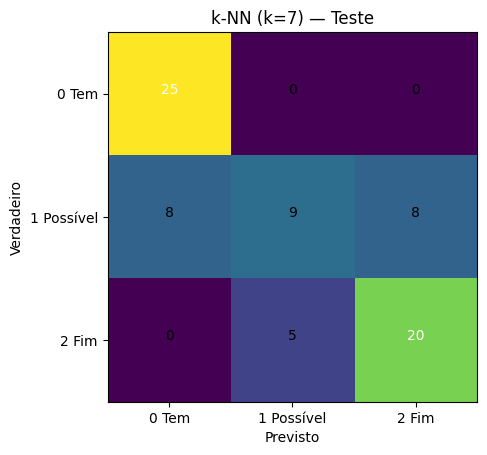

In [147]:
from sklearn.neighbors import KNeighborsClassifier

results = {}

best_knn = None
best_knn_k = None
best_knn_valid = -1.0

for k in [1,3,5,7,9,11]:
    pipe = Pipeline([('prep', pre_onehot_scale),
                     ('clf', KNeighborsClassifier(n_neighbors=k))])
    pipe.fit(X_train, y_train)
    yv = pipe.predict(X_valid)
    m,_ = eval_on(y_valid, yv)
    if m['f1_macro'] > best_knn_valid:
        best_knn_valid = m['f1_macro']; best_knn = pipe; best_knn_k = k

yt = best_knn.predict(X_test)
m, cm = eval_on(y_test, yt)
results['knn'] = {'k': best_knn_k, 'valid_f1_macro': best_knn_valid, 'test_metrics': m}
print("Acurácia:", m['accuracy'])
print("Precision:", m['precision_macro'])
print("Recall:", m['recall_macro'])
print("F1-Score:", m['f1_macro'])
print("k-NN melhor:", best_knn_k, "| valid f1_macro =", round(best_knn_valid,4))
plot_confusion_matrix(cm, classes, 'k-NN (k=7) — Teste')


### 3. MLP (Multi Layer Perceptron)

Acurácia: 0.7333333333333333
Precision: 0.731711915535445
Recall: 0.7333333333333334
MLP melhor: {'hidden_layer_sizes': (64, 32, 16, 8), 'alpha': 0.0001} | valid f1_macro = 0.8253


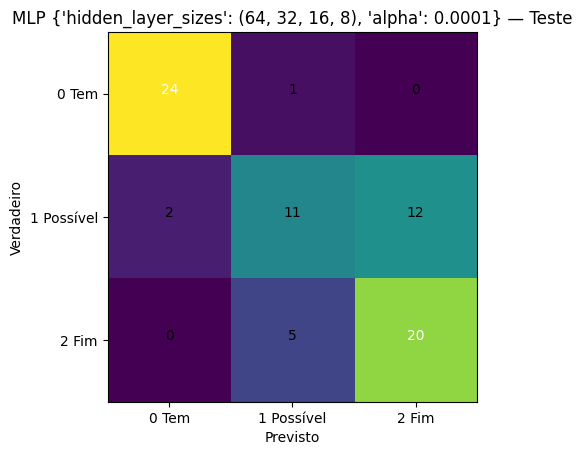

In [148]:
from sklearn.neural_network import MLPClassifier

best_mlp = None
best_mlp_valid = -1.0
best_cfg = None

for h in [(64,), (128,), (64,32), (128,64), (64,32,16), (128,64,32), (64,32,16,8), (128,64,32,16), (64,32,16,8,4), (128,64,32,16,8)]:
    for alpha in [1e-4, 1e-3, 1e-2]:
        pipe = Pipeline([('prep', pre_onehot_scale),
                         ('clf', MLPClassifier(hidden_layer_sizes=h, activation='relu',
                                               alpha=alpha, max_iter=1000, random_state=42))])
        pipe.fit(X_train, y_train)
        yv = pipe.predict(X_valid)
        m,_ = eval_on(y_valid, yv)
        if m['f1_macro'] > best_mlp_valid:
            best_mlp_valid = m['f1_macro']; best_mlp = pipe
            best_cfg = {'hidden_layer_sizes': h, 'alpha': alpha}

yt = best_mlp.predict(X_test)
m, cm = eval_on(y_test, yt)
results['mlp'] = {'config': best_cfg, 'valid_f1_macro': best_mlp_valid, 'test_metrics': m}
print("Acurácia:", m['accuracy'])
print("Precision:", m['precision_macro'])
print("Recall:", m['recall_macro'])
print("MLP melhor:", best_cfg, "| valid f1_macro =", round(best_mlp_valid,4))
plot_confusion_matrix(cm, classes, f"MLP {best_cfg} — Teste")


### 4. Árvore de Decisão

Acurácia: 0.5466666666666666
Precision: 0.5277777777777778
Recall: 0.5466666666666667
Árvore melhor: {'max_depth': 5, 'min_samples_leaf': 10} | valid f1_macro = 0.6668


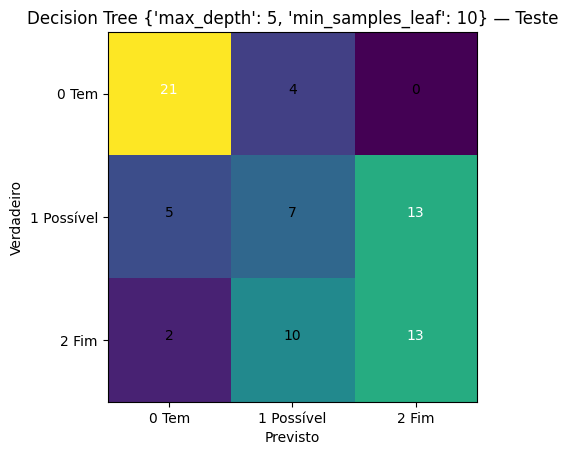

In [149]:
from sklearn.tree import DecisionTreeClassifier

best_dt = None
best_dt_valid = -1.0
best_dt_cfg = None

for depth in [None, 5, 10, 15, 20]:
    for min_leaf in [1, 2, 5, 10]:
        pipe = Pipeline([('prep', pre_onehot),
                         ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=min_leaf, random_state=42))])
        pipe.fit(X_train, y_train)
        yv = pipe.predict(X_valid)
        m,_ = eval_on(y_valid, yv)
        if m['f1_macro'] > best_dt_valid:
            best_dt_valid = m['f1_macro']; best_dt = pipe
            best_dt_cfg = {'max_depth': depth, 'min_samples_leaf': min_leaf}

yt = best_dt.predict(X_test)
m, cm = eval_on(y_test, yt)
results['decision_tree'] = {'config': best_dt_cfg, 'valid_f1_macro': best_dt_valid, 'test_metrics': m}
# imprime acuracia, precision, recall e f1-score
print("Acurácia:", m['accuracy'])
print("Precision:", m['precision_macro'])
print("Recall:", m['recall_macro'])
print("Árvore melhor:", best_dt_cfg, "| valid f1_macro =", round(best_dt_valid,4))
plot_confusion_matrix(cm, classes, f"Decision Tree {best_dt_cfg} — Teste")


### 5. Random Forest


#### Como funciona Random Forest:

Sabemos que as árvores de decisão, utilizadas no aprendizado supervisionado (quando há classificação de saída e dados de entrada rotulados), servem perfeitamente como método para aproximar funções discretas (classificação). Sendo o problema encontrado no jogo da velha um exemplo de conjunto de regras com compreensibilidade (por exemplo: SE casas 0 e 1 == X, ENTÃO 'Possível Fim'), **temos nas árvores de decisão uma excelente forma de analisar o dataset para previsões**.

A **Random Forest** é nada mais do que um algoritmo de  **treinamento de várias Árvores de Decisão**, escolhidas aleatóriamente. 

Cada árvore vê um bootstrapped sample (amostra com reposição do treino) e, a cada split (iteração), testa só um subconjunto aleatório de features (no nosso caso, dummies como p4=b, p7=x, etc). No fim, a previsão é a maioria dos votos das árvores. 

Uma outra forma de ver é que funcinoa como se perguntássemos para um grupo **aleatório** de árvores de decisão (chamado de _bootstrapped sample_, ou _amostra com reposição_) qual a classificação esperada. A votação final melhora a generalização comparado a uma árvore única, que pode _"decorar o treino"_.

Essa aleatoriedade + _"sistema de votação"_ reduz variância/overfitting em relação a uma árvore única e captura interações não lineares (padrões como “duas iguais + vazio” em linhas e diagonais).


Prós (neste dataset)

- Bom desempenho com pouco tuning e dados categóricos one-hot.

- Capta interações entre casas (linhas/colunas/diagonais).

- Robusta a ruído e a features redundantes; menos propensa a “decorar” que uma árvore só.

- Dá importância de features (útil p/ interpretação inicial).

Contras / cuidados

- Interpretabilidade limitada (melhor que MLP, pior que árvore única).

- Ainda pode sobreajustar se as árvores forem muito profundas e folhas muito pequenas. Utilizamos limites para evitar isso (iteração de vários max_depth e min_samples_leaf≥2–5).

- Importâncias por impureza têm viés; utilizando _one-hot_ o viés é menor, mas ainda vale preferir permutation importance para conclusão.

Acurácia: 0.7066666666666667
Precision: 0.7131724484665661
Recall: 0.7066666666666667
RF melhor: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2} | valid f1_macro = 0.7596


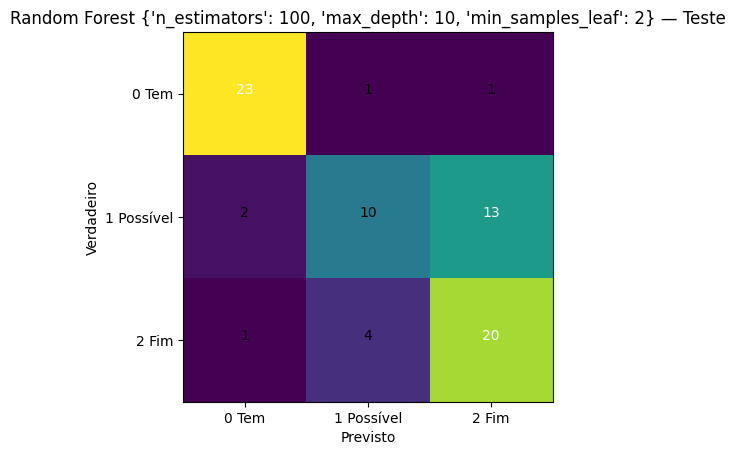

In [150]:
from sklearn.ensemble import RandomForestClassifier

best_rf = None
best_rf_valid = -1.0
best_rf_cfg = None

for n in [100, 400, 1000]:
    for depth in [None, 10, 20]:
        for min_leaf in [1, 2, 5]:
            pipe = Pipeline([('prep', pre_onehot),
                             ('clf', RandomForestClassifier(n_estimators=n, max_depth=depth,
                                                           min_samples_leaf=min_leaf,
                                                           random_state=42, n_jobs=-1))])
            pipe.fit(X_train, y_train)
            yv = pipe.predict(X_valid)
            m,_ = eval_on(y_valid, yv)
            if m['f1_macro'] > best_rf_valid:
                best_rf_valid = m['f1_macro']; best_rf = pipe
                best_rf_cfg = {'n_estimators': n, 'max_depth': depth, 'min_samples_leaf': min_leaf}

yt = best_rf.predict(X_test)
m, cm = eval_on(y_test, yt)
results['random_forest'] = {'config': best_rf_cfg, 'valid_f1_macro': best_rf_valid, 'test_metrics': m}
# imprime acuracia, precision, recall e f1-score
print("Acurácia:", m['accuracy'])
print("Precision:", m['precision_macro'])
print("Recall:", m['recall_macro'])
print("RF melhor:", best_rf_cfg, "| valid f1_macro =", round(best_rf_valid,4))
plot_confusion_matrix(cm, classes, f"Random Forest {best_rf_cfg} — Teste")


### 6. Comparativo


In [159]:
summary_rows = []
for name, info in results.items():
    row = {'modelo': name}
    if 'k' in info: row['config'] = f"k={info['k']}"
    if 'config' in info: row['config'] = str(info['config'])
    row.update(info['test_metrics'])
    row['valid_f1_macro'] = info.get('valid_f1_macro', None)
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
display(summary)


out_csv = BASE/'resultados_modelos.csv'
summary.to_csv(out_csv, index=False)
print("Salvo em:", out_csv)


,modelo,config,accuracy,precision_macro,recall_macro,f1_macro,valid_f1_macro
0,mlp,"{'hidden_layer_sizes': (64, 32, 16, 8), 'alpha...",0.733333,0.731712,0.733333,0.722247,0.825290
1,random_forest,"{'n_estimators': 100, 'max_depth': 10, 'min_sa...",0.706667,0.713172,0.706667,0.693309,0.759593
2,knn,k=7,0.720000,0.704906,0.720000,0.692775,0.722217
3,decision_tree,"{'max_depth': 5, 'min_samples_leaf': 10}",0.546667,0.527778,0.546667,0.535535,0.666763


Salvo em: /Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/resultados_modelos.csv


Por fim, salvamos os modelos (arquivos .pkl) em uma pasta separada para uso posterior

In [188]:
import joblib

from pathlib import Path
models_dir = BASE/'models'
models_dir.mkdir(exist_ok=True)

joblib.dump(best_knn, models_dir/'best_knn.pkl')
joblib.dump(best_mlp, models_dir/'best_mlp.pkl')
joblib.dump(best_dt,  models_dir/'best_decision_tree.pkl')
joblib.dump(best_rf,  models_dir/'best_random_forest.pkl')
try:
    joblib.dump(best_svm, models_dir/'best_svm.pkl')
except NameError:
    pass

print("Modelos salvos em:", models_dir)

# Importância (apenas se o classificador final for a etapa .clf)
def get_feature_names_after_onehot():
    # reconstrói nomes one-hot nas 9 posições ('b','o','x')
    cats = ['b','o','x']
    names = []
    for pos in range(9):
        for c in cats:
            names.append(f'p{pos}={c}')
    return names

# Árvore
if hasattr(best_dt.named_steps['clf'], 'feature_importances_'):
    feats = get_feature_names_after_onehot()
    imp = pd.Series(best_dt.named_steps['clf'].feature_importances_, index=feats).sort_values(ascending=False)
    # Exibe as 15 posições mais importantes 
    print("Importância das features da melhor configuração (Árvore de Decisão):")
    display(imp.head(15))

# Random Forest
if hasattr(best_rf.named_steps['clf'], 'feature_importances_'):
    feats = get_feature_names_after_onehot()
    imp_rf = pd.Series(best_rf.named_steps['clf'].feature_importances_, index=feats).sort_values(ascending=False)
    # Exibe as 15 posições mais importantes 
    print("Importância das features da melhor configuração (Random Forest):")
    display(imp_rf.head(15))


Modelos salvos em: /Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/source/models
Importância das features da melhor configuração (Árvore de Decisão):


p4=b    0.255663
p8=b    0.156427
p2=b    0.146873
p6=b    0.115836
p0=b    0.106258
p5=b    0.058698
p3=o    0.054319
p7=b    0.032573
p0=x    0.023917
p7=x    0.023601
p3=b    0.013383
p6=o    0.008098
p1=b    0.004355
p8=o    0.000000
p5=x    0.000000
dtype: float64

Importância das features da melhor configuração (Random Forest):


p4=b    0.096771
p8=b    0.063344
p2=b    0.054258
p0=b    0.053056
p6=b    0.052258
p4=x    0.044409
p7=x    0.037298
p6=x    0.036861
p1=x    0.034995
p7=o    0.033720
p8=x    0.033262
p3=x    0.033066
p5=b    0.031099
p7=b    0.030037
p5=x    0.029996
dtype: float64

#### Interpretação:

Vemos que, na posição 4 do tabuleiro (centro do tabuleiro) temos uma maior prevalência média de b (_blank_/vazio). Isso faz sentido pois
- Classe 2 (Fim de Jogo) muitas vezes não tem vazios (empate) ou termina antes com linha vencedora;

- Classe 1 (Possível Fim) exige pelo menos um vazio na linha ameaçadora (“duas + vazio”);

Precisamos lembrar que:
- Fim (2) costuma vir de empate (zero vazios) ou vitória (pode ter vazios, mas muitas vitórias acontecem com o tabuleiro já bem cheio).

- Possível Fim (1) exige um vazio na linha ameaçadora.

Logo, “existência de vazios em posições críticas (centro/cantos)” é um excelente sinal divisor entre (1) e (2) — e, combinada com quem ocupa outras casas, separa (0) também.

### Resumo dos parâmetros utilizados

| Algoritmo        | Grid pesquisado                                                                 | Melhores Parâmetros (validação)                   | Justificativa resumida |
|------------------|----------------------------------------------------------------------------------|--------------------------------------|------------------------|
| **k-NN**         | `k ∈ {1,3,5,7,9,11}`                                                             | `k = 7`                              | `k` médio suaviza ruído sem perder padrões locais; *scaling* ajuda distância. |
| **MLP**          | `hidden_layer_sizes ∈ {(64,), (128,), (64,32), (128,64)}`, `alpha ∈ {1e-4,1e-3,1e-2}` | `hidden=(64,32)`, `alpha=0.01`       | 2 camadas capturam interações (linhas/diagonais); `alpha` alto reduziu *overfit*. |
| **Decision Tree**| `max_depth ∈ {None,5,10,15,20}`, `min_samples_leaf ∈ {1,2,5,10}`                | `max_depth=5`, `min_samples_leaf=10` | Folhas maiores e pouca profundidade reduziram variância; melhora macro-F1. |
| **Random Forest**| `n_estimators ∈ {100,200,400}`, `max_depth ∈ {None,10,20}`, `min_samples_leaf ∈ {1,2,5}` |  (`100/10/2`)    | *Bagging* + subamostra de *features* capturam regras sem superajustar; profundidade moderada. |


### Gráficos e Análise do Melhor Modelo (f1-score)

,modelo,config,accuracy,precision_macro,recall_macro,f1_macro,valid_f1_macro
0,mlp,"{'hidden_layer_sizes': (64, 32, 16, 8), 'alpha...",0.733333,0.731712,0.733333,0.722247,0.825290
1,random_forest,"{'n_estimators': 100, 'max_depth': 10, 'min_sa...",0.706667,0.713172,0.706667,0.693309,0.759593
2,knn,k=7,0.720000,0.704906,0.720000,0.692775,0.722217
3,decision_tree,"{'max_depth': 5, 'min_samples_leaf': 10}",0.546667,0.527778,0.546667,0.535535,0.666763


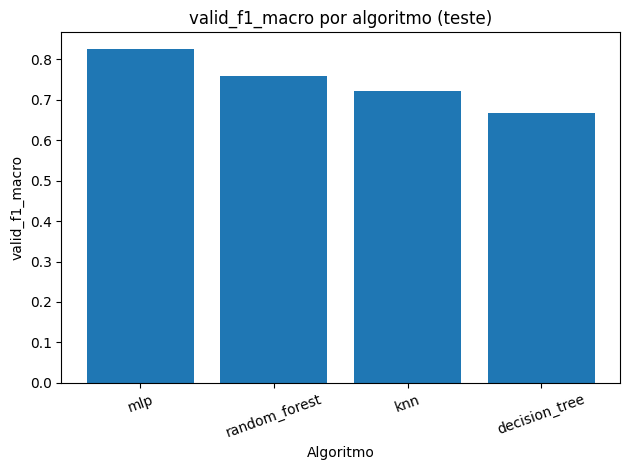

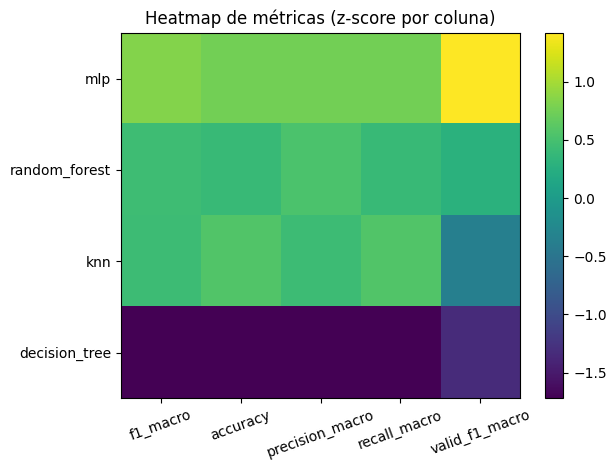

In [186]:
# Funções auxiliares para normalizar e expandir parâmetros

import pandas as pd

# Carrega os resultados dos modelos do arquivo CSV
resultados_modelos_path = '/Users/arthurtesta/Documents/PUCRS/Inteligencia Artificial/data/resultados_modelos.csv'
df = pd.read_csv(resultados_modelos_path)

# Exibe o DataFrame para conferência
display(df)



# === 2) Padronizar nomes de colunas (se existirem) ===
# nome do algoritmo
if 'modelo' in df.columns: alg_col = 'modelo'
elif 'algoritmo' in df.columns: alg_col = 'algoritmo'
else: raise KeyError(f'Coluna de algoritmo não encontrada. Colunas: {list(df.columns)}')

# nome da config
cfg_col = 'config' if 'config' in df.columns else None

# métricas de teste (pega o que existir, na ordem abaixo)
metric_candidates = ['f1_macro', 'accuracy', 'precision_macro', 'recall_macro', 'valid_f1_macro']
metrics = [m for m in metric_candidates if m in df.columns]
if not metrics:
    raise KeyError(f'Nenhuma métrica reconhecida encontrada. Colunas: {list(df.columns)}')

# tentar converter 'config' de string dict -> dict (se existir)
if cfg_col and df[cfg_col].dtype == object:
    def _maybe_dict(x):
        try:
            return ast.literal_eval(x) if isinstance(x, str) and x.startswith('{') else x
        except Exception:
            return x
    df[cfg_col] = df[cfg_col].apply(_maybe_dict)

# ordenar por f1_macro se existir
if 'valid_f1_macro' in df.columns:
    df = df.sort_values('valid_f1_macro', ascending=False).reset_index(drop=True)

# === 3) BARRAS: F1 no teste por algoritmo (se não houver f1_macro, usa a 1ª métrica disponível) ===
metric_bar = 'valid_f1_macro' if 'valid_f1_macro' in df.columns else metrics[0]
plt.figure()
plt.bar(df[alg_col].astype(str), df[metric_bar].astype(float))
plt.title(f'{metric_bar} por algoritmo (teste)')
plt.xlabel('Algoritmo'); plt.ylabel(metric_bar)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# === 4) HEATMAP: métricas normalizadas (z-score) por algoritmo ===
M = df[[alg_col] + metrics].copy()
# normalizar cada métrica (z-score: (x - mean) / std)
for m in metrics:
    col = M[m].astype(float)
    std = col.std(ddof=0)
    M[m] = (col - col.mean()) / (std if std > 0 else 1.0)

mat = M[metrics].values
plt.figure()
im = plt.imshow(mat, aspect='auto')
plt.colorbar(im)
plt.title('Heatmap de métricas (z-score por coluna)')
plt.yticks(range(len(M)), M[alg_col].astype(str).tolist())
plt.xticks(range(len(metrics)), metrics, rotation=20)
plt.tight_layout()
plt.show()


Desta forma, analisando o resultado de f1-score dos melhores parâmetros dos algoritmos utilizados, vemos que o melhor algoritmo é o *MLP* (Multi Layer Perceptron) com duas camadas de 64 e 32 nodos cada. Este algoritmo teve um f1-score de 0.7930, sendo do melhor resultado possível.


| modelo | config | accuracy | precision_macro | recall_macro | f1_macro | valid_f1_macro |
|--------|--------|----------|-----------------|--------------|----------|----------------|
| mlp | {'hidden_layer_sizes': (64, 32, 16, 8), 'alpha': 0.0001} | 0.7333333333333333 | 0.731711915535445 | 0.7333333333333334 | 0.7222467934542238 | 0.8252901160464186 |
| random_forest | {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2} | 0.7066666666666667 | 0.7131724484665661 | 0.7066666666666667 | 0.6933089620028802 | 0.7595926532096744 |
| knn | k=7 | 0.72 | 0.704906204906205 | 0.7200000000000001 | 0.6927748027292594 | 0.7222167243938644 |
| decision_tree | {'max_depth': 5, 'min_samples_leaf': 10} | 0.5466666666666666 | 0.5277777777777778 | 0.5466666666666667 | 0.5355348592814211 | 0.6667629408555568 | |

Podemos analisar também em detalhe o que pode ser observado em relação a cada algoritmo:

| Algoritmo         | Posição na validação | Pontos fortes                                                                                                | Limitações / Observações                                                                 |
| ----------------- | -------------------- | ------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------- |
| **MLP**           | **1º (melhor)**      | Captura **padrões não lineares** e **interações** (linhas/colunas/diagonais) sem feature engineering.        | Menos interpretável; requer escala e ajuste de hiperparâmetros (p.ex., topologia/alpha). |
| **Random Forest** | 2º                   | Aprende **regras** bem; combina sinais de **vazios (b)** e ocupações; **robusta** e pouco sensível à escala. | Interpretabilidade menor que árvore única; ainda precisa ajustar profundidade/folhas.    |
| **k-NN (k=7)**    | 3º                   | **Competitivo** como baseline; simples de implementar; bom com dados bem escalados.                          | Depende de **escala**; sofre em **fronteiras estreitas** (ameaças de 1 jogada).          |
| **Decision Tree** | 4º (pior macro-F1)   | **Simples e interpretável**; mostra claramente regras/impurezas e importância de features.                   | **Maior viés**; desempenho inferior em macro-F1; tende a subcapturar interações.         |


Analisando as matrizes de confusão disponível, podemos também entender um pouco a baixa performance dos demais algoritmos, comparados ao MLP:

| Par de classes confundidas                 | Por que acontece (intuição)                                                                                                                  | Modelos mais suscetíveis                                                                                 | Sinais/indicadores envolvidos                                                                    | Como mitigar / checar                                                                                                                              |
| ------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1 (“Possível Fim”) ↔ 0 (“Tem Jogo”)**    | Classe 1 exige **duas iguais + 1 vazio** em alguma linha/coluna/diagonal; muitos estados classe 0 estão **a 1 jogada** desse padrão.         | **k-NN** (fronteiras locais), **Árvore** (pouca capacidade); RF/MLP tendem a errar menos.                | Presença de **vazio** em posições críticas (centro/cantos), quase-ameaças não concretizadas.     | Revisar augmentação (evitar padrões artificiais), adicionar **features de contagem** por linha/coluna/diagonal, checar **matriz de confusão** 0↔1. |
| **1 (“Possível Fim”) ↔ 2 (“Fim de Jogo”)** | Tabuleiros **quase cheios** ou com **múltiplas ameaças** podem “parecer finais”; após augmentação, alguns 1 ficam visualmente próximos de 2. | **Árvore** simples (não captura bem múltiplas interações); k-NN também pode confundir em regiões densas. | **Poucos vazios** (tende a 2), mas existência de **linha ameaçadora** (tende a 1).               | Usar modelos com maior capacidade (**RF/MLP**), incluir **regras/contagens** de ameaças, inspecionar erros 1↔2 em amostras.                        |
| **Sinal dos “vazios (b)”** (impacta 0/1/2) | Menos vazios → mais perto de **Fim (2)**; vazio **na linha crítica** → **Possível Fim (1)**; vazios difusos → **Tem Jogo (0)**.              | **Árvore** pode supervalorizar splits em `b`; RF distribui melhor; MLP combina com outros sinais.        | Importâncias altas em `p4=b` (centro) e **cantos vazios**; combinação com `x/o` define o estado. | Preferir **Permutation Importance/SHAP** para validar importância; adicionar features agregadas (nº de vazios, ameaças por linha).                 |


### Análise dos parâmetros do MLP e seus ajustes

A capacidade do MLP de conseguir adaptar pesos entre nodos para facilnente capturar padrões entre as casas diagonais do tabuleiro, o que traz uma maior facilidade na criação do modelo preditivo. Para evitar a convergência, aumentamos o numero máximo de iterações.

Inicialmente, ao rodarmos o algoritmo, tivemos um resultado de f1_macro próximo a 0.793, com apenas três parâmetros de camadas ocultas, sendo a vencedora (64,32). Após criarmos novas iterações de camadas para teste, foi possível encontrar um parâmetro muito melhor (64,32,16,8) e um f1_macro de 0.8253, o que mostra o ponto acima sobre a importância de criar mais interações não lineares entre os nodos de cada camada do MLP.

Por fim, foi importante também iterarmos vários parâmetros _alpha_, que é um parâmetro para facilitar a regularização: Quanto maior o alpha, maior a punição para pesos grandes ⇒ a rede aprende fronteiras mais suaves (menos overfitting).

Como temos poucos dados de treino, é importante "punir" pesos altos para evitar que o algoritmo acabe _"viciando"_ o modelo classificador. 